In [226]:
from zentools.data_operations import slice_dataframe_by_date, add_macd, add_ewm_rsi, add_rsi
import pandas as pd
import numpy as np

In [227]:
# Load the CSV without the deprecated 'date_parser'
data = pd.read_csv("/home/bobo/Documents/Datasets/Binance_ETHUSDT_1h .csv", parse_dates=["Date"], index_col="Date")

# Convert the index to datetime manually (to ensure proper handling of any date format)
data.index = pd.to_datetime(data.index, format='ISO8601')

# Sort the DataFrame by index
data = data.sort_index()

In [228]:
add_macd(data, 12, 26, 9)
add_rsi(data)
data['Close'] = data['Close'].pct_change()
data['Volume ETH'] = data['Volume ETH'].pct_change()
data['EMA_12'] = data['EMA_12'].pct_change()
data['EMA_26'] = data['EMA_26'].pct_change()
data['tradecount'] = data['tradecount'].pct_change()
# clip
data['Close'] = data['Close'].clip(-1, 1)
data['Volume ETH'] = data['Volume ETH'].clip(-1, 1)
data['EMA_12'] = data['EMA_12'].clip(-1, 1)
data['EMA_26'] = data['EMA_26'].clip(-1, 1)
data['tradecount'] = data['tradecount'].clip(-1, 1)
# Replace +inf and -inf with NaN
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data = data.fillna(0)

In [229]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

In [230]:
data

,Symbol,Open,High,Low,Close,Volume ETH,Volume USDT,tradecount,EMA_12,EMA_26,MACD,Signal_Line,Histogram,RSI
Date,,,,,,,,,,,,,,
2017-08-17 04:00:00,ETHUSDT,301.13,302.57,298.00,0.000000,0.000000,3.768480e+04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2017-08-17 05:00:00,ETHUSDT,301.61,303.28,300.00,0.004940,1.000000,1.140433e+05,0.565891,0.000760,0.000366,0.118860,0.023772,0.095088,0.000000
2017-08-17 06:00:00,ETHUSDT,302.40,304.44,301.90,-0.001386,-0.195423,9.203444e+04,-0.099010,0.000429,0.000236,0.177126,0.054443,0.122683,0.000000
2017-08-17 07:00:00,ETHUSDT,302.68,307.96,302.60,0.017444,1.000000,2.297251e+05,0.087912,0.003052,0.001514,0.641953,0.171945,0.470008,0.000000
2017-08-17 08:00:00,ETHUSDT,307.95,309.97,307.00,0.002143,-0.800263,4.655946e+04,-0.080808,0.002910,0.001562,1.051468,0.347850,0.703619,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-19 19:00:00,ETHUSDT,1561.66,1569.92,1561.20,0.004053,-0.205835,9.540306e+06,-0.121583,0.000950,0.000414,-0.070462,-2.304089,2.233627,74.061433
2023-10-19 20:00:00,ETHUSDT,1568.00,1573.15,1563.72,-0.000950,0.432029,1.369178e+07,0.195026,0.000656,0.000312,0.465192,-1.750233,2.215425,73.333333
2023-10-19 21:00:00,ETHUSDT,1566.51,1567.72,1563.39,-0.001947,-0.399413,8.200644e+06,-0.207436,0.000254,0.000144,0.636258,-1.272935,1.909193,66.495287


In [231]:
# Assuming Date is already the index, only select the relevant features (excluding Date)
features = ['Close', 'Volume ETH', 'tradecount','EMA_12', 'EMA_26', 'MACD', 'RSI']
X = data[features]  # Only select the columns, not the index
y = data['Close']  # Assuming your target column is 'target'

In [307]:
# Split into training and testing sets
# Remove rows with NaN values in the target variable
X_cleaned = X[~y.isna()]
y_cleaned = y.dropna()

# Ensure X and y have the same length
assert len(X_cleaned) == len(y_cleaned)

# Now you can split and train your model
X_train, X_test, y_train, y_test = train_test_split(X_cleaned, y_cleaned, test_size=0.75, random_state=42)

In [308]:
# Define the pipeline
pipe = Pipeline([
    ("scale", MinMaxScaler()),  # Feature scaling
    ("model", RandomForestRegressor(random_state=42))  # Random Forest Regressor for continuous target
])

In [309]:
param_grid = {
    'model__n_estimators': [100, 200],  # Number of trees
    'model__max_depth': [None, 10, 20],  # Maximum depth of the trees
    'model__min_samples_split': [2, 5],  # Minimum samples to split an internal node
    'model__min_samples_leaf': [1, 2],  # Minimum samples in the leaf nodes
    'model__max_features': ['sqrt', 'log2']  # Max features options
}

In [310]:
# Set up GridSearchCV
grid_search = GridSearchCV(pipe, param_grid, cv=3, n_jobs=-1, verbose=2)

In [311]:
# Fit the model
# grid_search.fit(X_train, y_train)

In [312]:
# Output the best parameters and best score
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: ", grid_search.best_score_)

# Evaluate on test set
print("Test set score: ", grid_search.score(X_test, y_test))

AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

In [313]:
# Define the model and the optimal hyperparameters
rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=10,
    max_features='sqrt',
    min_samples_split=10,
    min_samples_leaf=4,
    n_jobs=-1,  # To use all processors during training
    random_state=42
)
from sklearn.neural_network import MLPRegressor
# Create the pipeline
pipe = Pipeline([
    ('scaler', MinMaxScaler()),  # Standardize features
    ('model', MLPRegressor())  # RandomForestClassifier with optimal hyperparameters
])

In [314]:
# Fit the model on the training data
pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', MinMaxScaler()), ('model', MLPRegressor())])

In [315]:
y_pred = pipe.predict(X_test)

In [316]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Actual vs Predicted Returns')

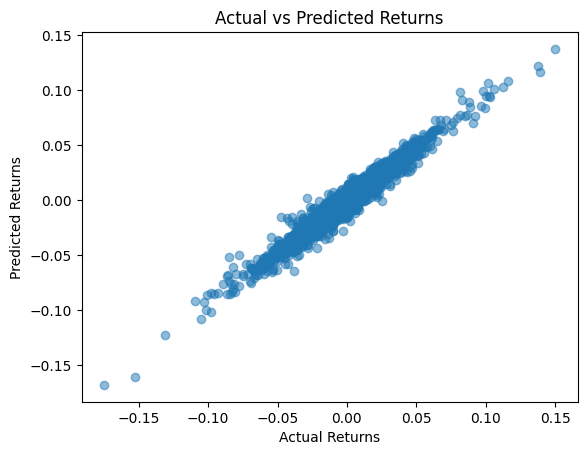

In [317]:
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual Returns")
plt.ylabel("Predicted Returns")
plt.title("Actual vs Predicted Returns")

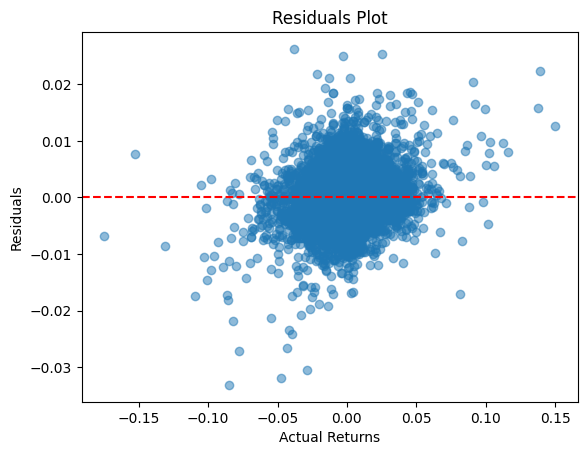

In [318]:
# Calculate residuals
residuals = y_test - y_pred

# Scatter plot of residuals
plt.scatter(y_test, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Actual Returns")
plt.ylabel("Residuals")
plt.title("Residuals Plot")
plt.show()

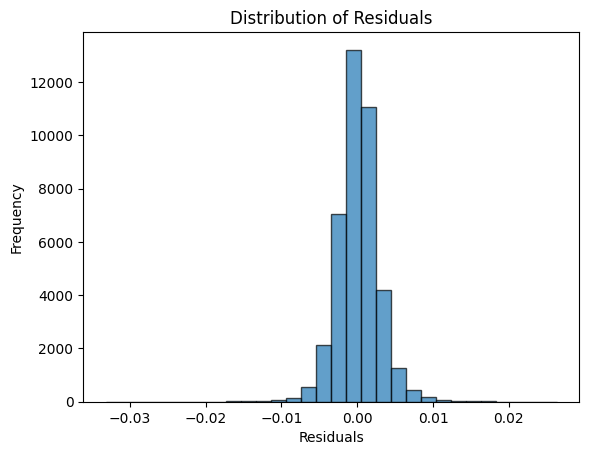

In [319]:
# Histogram of residuals
plt.hist(residuals, bins=30, edgecolor='k', alpha=0.7)
plt.title("Distribution of Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()

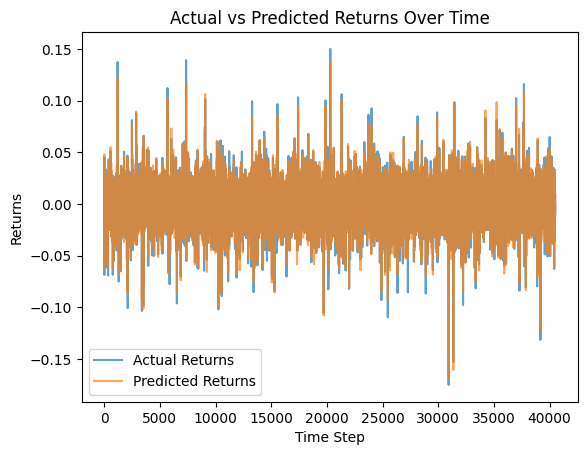

In [320]:
# Line plot for actual and predicted values
plt.plot(y_test.reset_index(drop=True), label="Actual Returns", alpha=0.7)
plt.plot(y_pred, label="Predicted Returns", alpha=0.7)
plt.xlabel("Time Step")
plt.ylabel("Returns")
plt.title("Actual vs Predicted Returns Over Time")
plt.legend()
plt.show()